# Process, Clean, and Save all Auxiliary Data Sets

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import pickle
from astropy.time import Time
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import rioxarray as rxr
from scipy.signal import savgol_filter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

## Clean CDEC Data and Save to Pickle

## Load CDEC Snow Depth for same date range and add to time series  
-> Only run this once, then load the pickle file to avoid redundancy

#### To Do: Check out SNOTEL access API - they have CDEC sites too!

In [3]:
tum = pd.read_csv('../data/CDEC/TUM_18.csv')
dan = pd.read_csv('../data/CDEC/DAN_18.csv')

tum = tum.rename(columns={'OBS DATE':'OBS_DATE', 'DATE TIME':'DATE_TIME'})
dan = dan.rename(columns={'OBS DATE':'OBS_DATE', 'DATE TIME':'DATE_TIME'})

In [4]:
tum_elev = 2621.28
dan_elev = 2965

In [5]:
# from stack overflow

from datetime import date


def int2date(argdate: int) -> date:
    """
    If you have date as an integer, use this method to obtain a datetime.date object.

    Parameters
    ----------
    argdate : int
      Date as a regular integer value (example: 20160618)

    Returns
    -------
    dateandtime.date
      A date object which corresponds to the given value `argdate`.
    """
    year = int(argdate / 10000)
    month = int((argdate % 10000) / 100)
    day = int(argdate % 100)

    return date(year, month, day)

#### Fill in Nan values so OBS_DATE can be converted to DateTimeIndex  
I found the locations where this column was Nan, and then used the dates on either side to fill in.

In [6]:
tum.loc[126, 'OBS_DATE'] = 20190204.0
tum.loc[134, 'OBS_DATE'] = 20190212.0
tum.loc[394, 'OBS_DATE'] = 20191030.0

#### Convert snow depth from inches to meters, convert time to datetime index, add doy

In [11]:
snwd = pd.DataFrame([tum.OBS_DATE, tum.VALUE]).transpose()
snwd.VALUE = snwd.VALUE * 2.54/100
snwd = snwd.rename(columns={'VALUE':'tum_m'})
snwd['dan_m'] = dan.VALUE * 2.54/100

snwd['Date'] = snwd['OBS_DATE'].map(lambda x: int(x))
snwd['Date'] = pd.DatetimeIndex(snwd['Date'].map(lambda x: int2date(x)))

snwd = snwd.set_index('Date')
snwd.sort_index(inplace=True)
snwd = snwd.drop(columns=['OBS_DATE'])
add_dowy(snwd)

Adding Day of Water Year (DOWY)


In [54]:
#snwd = snwd[snwd['tum_m'] < 2.9]

In [12]:
snwd.head(2)

,tum_m,dan_m,doy,decyear,dowy
Date,,,,,
2018-10-01,0.0254,-0.0508,274,2018.747945,1
2018-10-02,0.0000,NaN,275,2018.750685,2


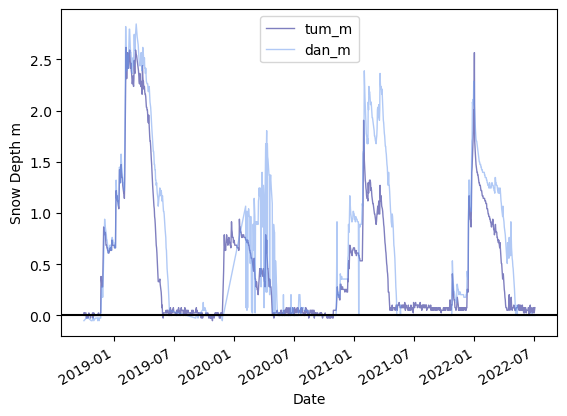

In [14]:
fig, ax = plt.subplots()
snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.5, color='navy', lw=1)
snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.5, color='cornflowerblue', lw=1)
ax.axhline(y = 0, c = 'k')
plt.ylabel('Snow Depth m')
plt.legend()

In [51]:
# Save the combined geodataframe of the two cdec sites

out_fn = '../data/CDEC/cdec_gdf.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(snwd, f)

## Clean Dana Meadows CDEC data  
Specifically 2020 winter is all over the place

In [6]:
snwd = pickle.load(open('../data/CDEC/cdec_gdf.pkl', 'rb'))

(18140.0, 18506.0)

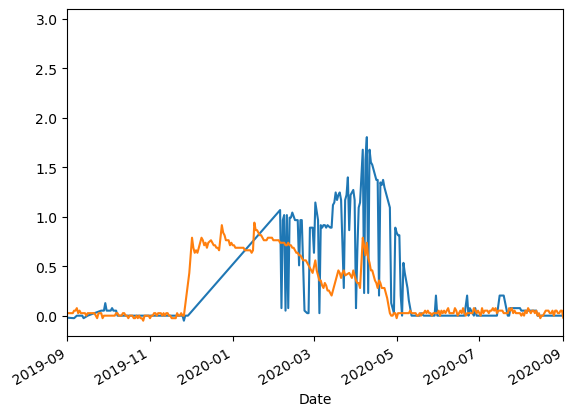

In [7]:
# try a smoothing algorithm

dt_min_plot = '2019-09-01'
dt_max_plot = '2020-09-01'

fig, ax = plt.subplots()

snwd[snwd['dan_m']<2.99]['dan_m'].plot(ax=ax)
snwd[snwd['tum_m']<2.99]['tum_m'].plot(ax=ax)
ax.set_xlim([dt_min_plot, dt_max_plot])

(18140.0, 18506.0)

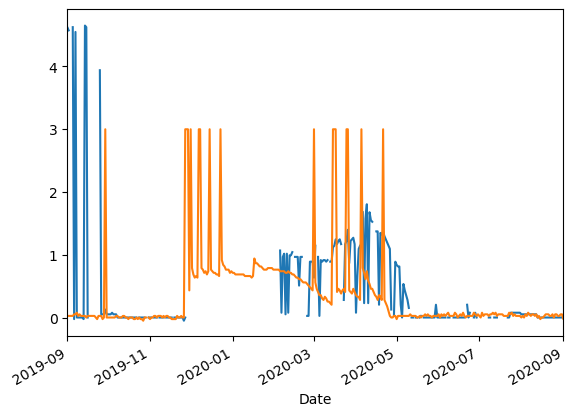

In [8]:
dt_min_plot = '2019-09-01'
dt_max_plot = '2020-09-01'

fig, ax = plt.subplots()

snwd['dan_m'].plot(ax=ax)
snwd['tum_m'].plot(ax=ax)
ax.set_xlim([dt_min_plot, dt_max_plot])

Steps in the following cells:  
* Make a new dataframe of only dana, so that I can remove outliers. 
* Fit a smoothed line to the data. 
* Offset this smoothed line so that values below the line appear to be mistakes in the data, and above the line is data we want to preserve.   

In [36]:
dana_df = pd.DataFrame([snwd.index, snwd.dan_m]).transpose()
dana_df = dana_df.rename(columns={0:'date', 1:'dan_m'})
dana_df = dana_df.set_index('date')
dana_df = dana_df.dropna()
dana_df = dana_df[dana_df['dan_m'] < 2.99]
#dana_df['dan_dif'] = pd.Series(dana_df['dan_m'].diff())
dana_df.head()

,dan_m
date,
2018-10-01,-0.0508
2018-10-08,-0.0254
2018-10-10,-0.0254
2018-10-14,-0.0254
2018-10-15,-0.0254


In [52]:
# Get rid of the problem data, that all appear to be above 2.99m
snwd[snwd['tum_m']>2.99] = np.nan
snwd[snwd['dan_m']>2.99] = np.nan
# Apply the smoothing function
dana_df['dan_filtered'] = savgol_filter(dana_df['dan_m'], 50, 2)
snwd['dan_filtered'] = dana_df['dan_filtered']
# Offset the smoothed function
snwd['dan_filtered_offset'] = snwd['dan_filtered'] - 0.3

In [53]:
snwd['dan_clean'] = np.nan
for i in range(len(snwd)):
    if snwd['dan_m'][i] > snwd['dan_filtered_offset'][i]:
        snwd['dan_clean'][i] = snwd['dan_m'][i]

remove a single date of erroneous data at Dana that was bothering me:

In [60]:
snwd.loc['2020-02-19', 'dan_clean'] = np.nan

<AxesSubplot: xlabel='Date'>

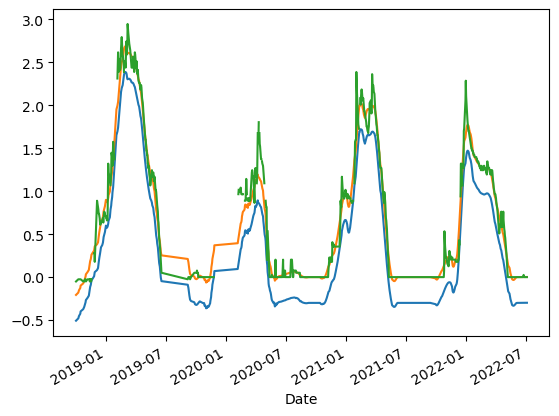

In [64]:
fig, ax = plt.subplots()
#snwd[snwd['dan_m']>2.99]['dan_m'].plot(ax=ax)
snwd[snwd['dan_m']<2.99]['dan_filtered_offset'].plot(ax=ax)
snwd[snwd['dan_m']<2.99]['dan_filtered'].plot(ax=ax)
snwd[snwd['dan_m']<2.99]['dan_clean'].plot(ax=ax)

<AxesSubplot: xlabel='Date'>

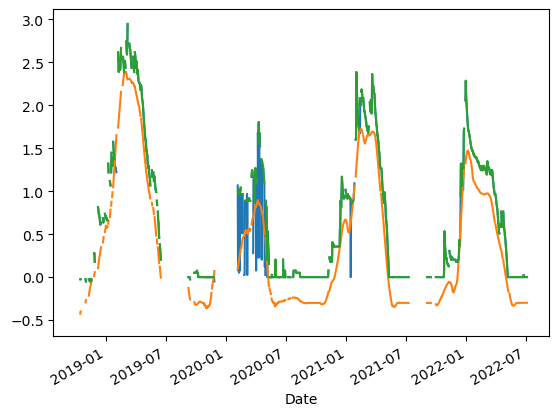

In [65]:
fig, ax = plt.subplots()
snwd['dan_m'].plot(ax=ax)
snwd['dan_filtered_offset'].plot(ax=ax)
snwd['dan_clean'].plot(ax=ax)

(18140.0, 18506.0)

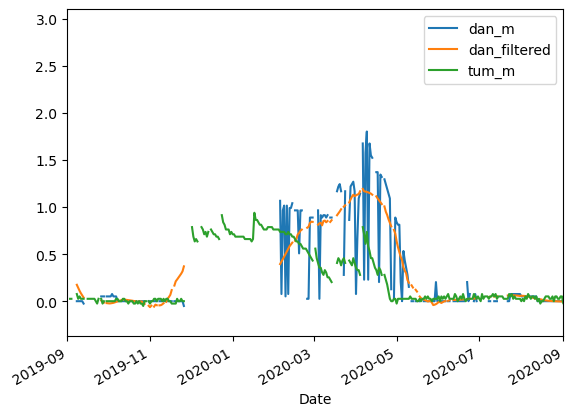

In [66]:
dt_min_plot = '2019-09-01'
dt_max_plot = '2020-09-01'

fig, ax = plt.subplots()
snwd[['dan_m', 'dan_filtered', 'tum_m']].plot(ax=ax)
ax.set_xlim([dt_min_plot, dt_max_plot])

In [31]:
snwd.head()

,tum_m,dan_m,doy,decyear,dowy,dan_filtered,dan_filtered_offset,dan_clean
Date,,,,,,,,
2018-10-01,0.0254,-0.0508,274.0,2018.747945,1.0,-0.207324,-0.507324,-0.0508
2018-10-02,0.0000,NaN,275.0,2018.750685,2.0,NaN,NaN,NaN
2018-10-03,0.0254,NaN,276.0,2018.753425,3.0,NaN,NaN,NaN
2018-10-04,0.0254,NaN,277.0,2018.756164,4.0,NaN,NaN,NaN
2018-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: xlabel='Date'>

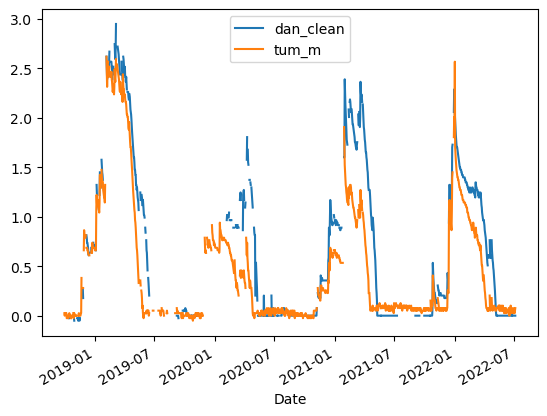

In [67]:
snwd[['dan_clean', 'tum_m']].plot()

In [68]:
snwd = snwd.drop(columns=['dan_filtered', 'dan_filtered_offset'])

In [69]:
# Save the combined geodataframe of the two cdec sites

out_fn = '../data/CDEC/cdec_gdf.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(snwd, f)

## Create GDF of CDEC Coordinates and Radius 

In [77]:
tum_elev = 2621.28
dan_elev = 2965

tum_coords = [37.873000,-119.350000]
dan_coords = [37.897000,-119.257000]

tum_band = [2371.28, 2871.28]
dan_band = [2715,3215]

In [78]:
dan_elev - 250

2715

### Create 5 km radius around TUM CDEC site

In [92]:
# Create a transform that will go from the native ICESat-2 and Snotel CS (4326) to the common projection we will use (32610, ie UTM Zone 10 N)

target_crs = "EPSG:32611"
from pyproj import Transformer,CRS
to_target_crs = Transformer.from_crs(4326,target_crs)

In [93]:
# Transform the snotel site locations to 32610
# Originally written by Hannah for Methow notebook

points_cdec = []
cdec_coords = [(37.873000,-119.350000,2621.28),(37.897000,-119.257000,2965)]
for pt in to_target_crs.itransform(cdec_coords):
    points_cdec.append(pt)
x_cdec = [x_tuple[0] for x_tuple in points_cdec]
y_cdec = [y_tuple[1] for y_tuple in points_cdec]
z_cdec = [z_tuple[2] for z_tuple in points_cdec]
cdec_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x_cdec, y_cdec), crs='epsg:32611')
cdec_gdf['elevation_m'] = z_cdec

<AxesSubplot: >

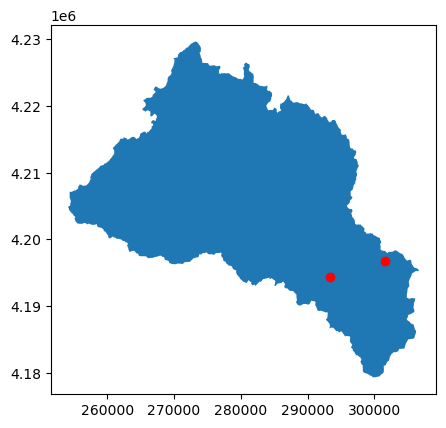

In [94]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_gdf.plot(ax=ax, c='r')

In [95]:
cdec_gdf['site'] = ''
cdec_gdf.loc[0, 'site'] = 'tum'
cdec_gdf.loc[1, 'site'] = 'dan'
cdec_gdf

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan


In [96]:
from shapely.geometry import Point

tum = Point((cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.x, cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.y))
dan = Point((cdec_gdf[cdec_gdf['site'] == 'dan'].geometry.x, cdec_gdf[cdec_gdf['site'] == 'dan'].geometry.y))

In [97]:
df_center= pd.DataFrame({'site':'tum_5km','geometry':[tum]})
df_center.loc[len(df_center)]={'site':'dan_5km', 'geometry':dan}
df_center

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/construction.py:810: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)


,site,geometry
0,tum_5km,POINT (293306.5622950811 4194327.334556827)
1,dan_5km,POINT (301551.8767049168 4196788.618859532)


In [98]:
gdf_center = gpd.GeoDataFrame(df_center, geometry=df_center['geometry'], crs='epsg:32611')
gdf_center['geometry'] = gdf_center.geometry.buffer(5000)
gdf_center

,site,geometry
0,tum_5km,"POLYGON ((298306.562 4194327.335, 298282.486 4..."
1,dan_5km,"POLYGON ((306551.877 4196788.619, 306527.800 4..."


<AxesSubplot: >

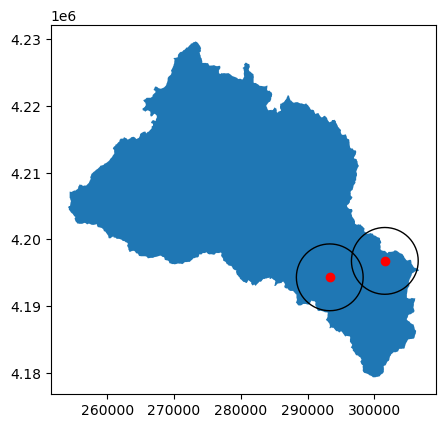

In [99]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_gdf.plot(ax=ax, c='r')
gdf_center.plot(ax=ax, facecolor='none')

## Combine the geodataframes

In [100]:
cdec_geom = pd.concat([cdec_gdf, gdf_center], ignore_index=True)
cdec_geom

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan
2,"POLYGON ((298306.562 4194327.335, 298282.486 4...",NaN,tum_5km
3,"POLYGON ((306551.877 4196788.619, 306527.800 4...",NaN,dan_5km


<AxesSubplot: >

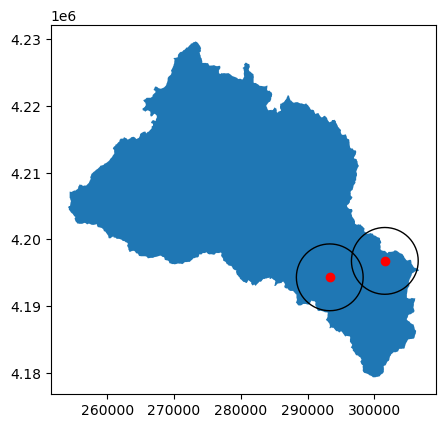

In [101]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_geom[cdec_geom.geometry.geom_type == 'Point'].plot(ax=ax, color='r')
cdec_geom[cdec_geom.geometry.geom_type == 'Polygon'].plot(ax=ax, facecolor='none', edgecolor='k')
# cdec_gdf.plot(ax=ax, c='r')
# gdf_center.plot(ax=ax, facecolor='none')

In [102]:
cdec_geom.crs

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Save the radius geodataframes

In [103]:
cdec_out_fn = '../data/CDEC/cdec_geometries.pkl'

with open(cdec_out_fn, 'wb') as f:
    pickle.dump(cdec_geom, f)

## Clean the Tuolumne Outline file

In [34]:
outline_gdf = gpd.read_file('../data/UpperTuolRiverBasinOutline.geojson')
outline_gdf = outline_gdf[0:1]
outline_gdf = outline_gdf.to_crs('EPSG:32611')

outline_fn = '../../data/site_outlines/tuolumne_outline_32611'

with open(outline_fn, 'wb') as f:
    pickle.dump(outline_gdf, f)

# Clip Lakes to Tuolumne 

In [10]:
outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))

In [27]:
lakes = gpd.read_file('../../data/site_outlines/California_Lakes.geojson')

In [29]:
lakes = lakes.to_crs('EPSG:32611')

In [36]:
lakes = gpd.clip(lakes, outline_gdf)

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

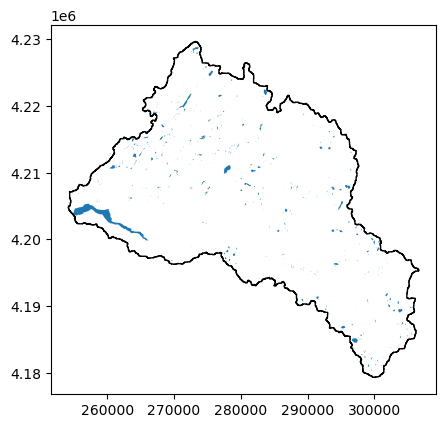

In [37]:
fig, ax = plt.subplots()

lakes.plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none')

In [38]:
out_fn = '../../data/site_outlines/lakes_tuolumne.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(lakes, f)

## Clip Streamlines to Tuolumne

In [6]:
streamlines = gpd.read_file('../../data/misc/NHD_H_18040009_HU8_Shape/Shape/NHDFlowline.shp')

In [7]:
streamlines = streamlines.to_crs('epsg:32611')

<AxesSubplot: >

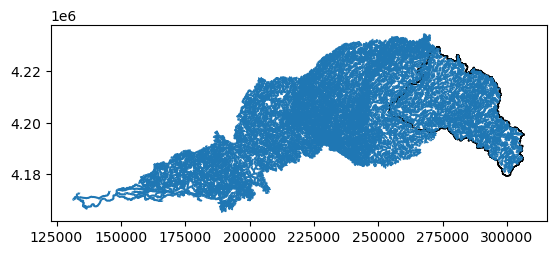

In [11]:
fig, ax = plt.subplots()
streamlines.plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

In [12]:
streamlines_tuol = gpd.clip(streamlines, outline_gdf)

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

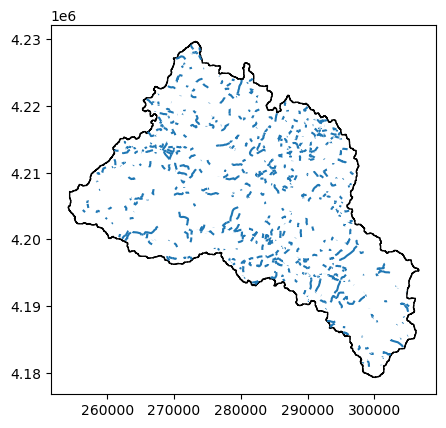

In [28]:
fig, ax = plt.subplots()
streamlines_tuol[streamlines_tuol['lengthkm'] > 1].plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

In [24]:
streamlines_tuol['resolution']

46340    2
10181    2
39120    2
33017    2
14626    2
        ..
38205    2
38853    2
38570    2
37777    2
39325    2
Name: resolution, Length: 5431, dtype: int64

In [15]:
streamlines_tuol.head(5)

,permanent_,fdate,resolution,gnis_id,gnis_name,lengthkm,reachcode,flowdir,wbarea_per,ftype,fcode,mainpath,innetwork,visibility,SHAPE_Leng,Enabled,ObjectID,geometry
46340,66749725,2017-11-02,2,None,None,0.046632,18040009004056,1,66759189,558,55800,0,1,100000,0.000518,1,46341,"LINESTRING Z (280926.412 4212583.477 0.000, 28..."
10181,66749961,2018-05-24,2,None,None,0.095268,18040009007854,1,66759207,558,55800,0,1,250000,0.000872,1,10182,"LINESTRING Z (291881.365 4190935.179 0.000, 29..."
39120,{BEB12D3E-5CE3-47C5-BD78-EEDCDDD8754A},2020-09-29,2,00253760,Piute Creek,0.544118,18040009004060,1,None,460,46006,0,1,2000000,0.005734,1,39121,"LINESTRING Z (294077.411 4190625.172 0.000, 29..."
33017,{083C8569-5E7F-4665-A5B7-B9FA6285313C},2020-09-29,2,None,None,0.631592,18040009045629,1,None,460,46007,0,1,24000,0.006966,1,33018,"LINESTRING Z (299110.444 4190866.215 0.000, 29..."
14626,66749935,2012-01-24,2,None,None,0.085000,18040009007853,1,66759207,558,55800,0,1,24000,0.000928,1,14627,"LINESTRING Z (293531.232 4190435.227 0.000, 29..."


In [27]:
streamlines_tuol['lengthkm'].describe()

count    5431.000000
mean        0.502948
std         0.492807
min         0.002120
25%         0.118355
50%         0.375242
75%         0.739512
max         4.524204
Name: lengthkm, dtype: float64

In [51]:
nhdplus = gpd.read_file('../../data/misc/NHDPLUS_H_1804_HU4_GDB/NHDPLUS_H_1804_HU4_GDB.gdb/', layer=11)

In [52]:
nhdplus

,NHDPlusID,StreamLeve,StreamOrde,StreamCalc,FromNode,ToNode,HydroSeq,LevelPathI,PathLength,TerminalPa,ArbolateSu,Divergence,StartFlag,TerminalFl,UpLevelPat,UpHydroSeq,DnLevel,DnLevelPat,DnHydroSeq,DnMinorHyd,DnDrainCou,FromMeas,ToMeas,ReachCode,RtnDiv,Thinner,VPUIn,VPUOut,AreaSqKm,TotDASqKm,DivDASqKm,MaxElevRaw,MinElevRaw,MaxElevSmo,MinElevSmo,Slope,SlopeLenKm,ElevFixed,HWType,HWNodeSqKm,StatusFlag,VPUID,geometry
0,5.000080e+13,5,1,1,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,471.461235,5.000080e+13,0.377000,0,1,0,0.000000e+00,0.000000e+00,5,5.000080e+13,5.000080e+13,0.000000e+00,1,54.113701,100.00000,18040006066209,0,NaN,0,0,0.0549,0.054900,0.0549,71634.0,68179.0,71634.0,68179.0,0.124729,0.277000,0.0,0.0,0.0223,A,1804,None
1,5.000080e+13,4,1,1,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,495.429532,5.000080e+13,0.471086,0,1,0,0.000000e+00,0.000000e+00,3,5.000080e+13,5.000080e+13,0.000000e+00,1,0.000000,100.00000,18040006068974,0,NaN,0,0,0.0955,0.095500,0.0955,140935.0,131943.0,140935.0,131943.0,0.242316,0.371086,1.0,0.0,0.0536,A,1804,None
2,5.000080e+13,6,1,1,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,543.123097,5.000080e+13,0.092585,0,1,0,0.000000e+00,0.000000e+00,5,5.000080e+13,5.000080e+13,0.000000e+00,1,55.130322,100.00000,18040006055207,0,NaN,0,0,0.0108,0.010800,0.0108,285435.0,285432.0,285435.0,285432.0,0.004500,0.006667,1.0,0.0,0.0100,A,1804,None
3,5.000080e+13,5,1,1,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,540.278892,5.000080e+13,0.300382,0,1,0,0.000000e+00,0.000000e+00,5,5.000080e+13,5.000080e+13,0.000000e+00,1,5.342410,100.00000,18040006056972,0,NaN,0,0,0.0522,0.052200,0.0522,283267.0,282853.0,283267.0,282853.0,0.020661,0.200382,0.0,0.0,0.0090,A,1804,None
4,5.000080e+13,4,1,1,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,298.763863,5.000080e+13,0.142802,0,1,0,0.000000e+00,0.000000e+00,4,5.000080e+13,5.000080e+13,0.000000e+00,1,0.000000,100.00000,18040010014556,0,NaN,0,0,0.0155,0.015500,0.0155,181205.0,180442.0,181205.0,180469.0,0.171953,0.042802,0.0,0.0,0.0108,A,1804,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372066,5.000080e+13,5,3,0,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,47.886436,5.000080e+13,16790.200865,2,0,0,5.000080e+13,5.000080e+13,4,5.000080e+13,5.000080e+13,0.000000e+00,1,0.000000,100.00000,18040012025644,1,NaN,0,0,0.0041,5107.372898,0.0041,-9998.0,-231.0,0.0,0.0,0.000010,0.402339,1.0,NaN,NaN,A,1804,None
372067,5.000080e+13,6,3,0,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,1.170565,5.000080e+13,15.846753,2,0,0,5.000080e+13,5.000080e+13,5,5.000080e+13,5.000080e+13,0.000000e+00,1,91.869057,99.01371,18040012018731,0,NaN,0,0,0.0141,10.325400,0.0141,-9998.0,703.0,722.0,713.0,0.001346,0.066872,1.0,NaN,NaN,A,1804,None
372068,5.000080e+13,4,2,0,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,0.000000,5.000080e+13,11.162773,2,0,1,5.000080e+13,5.000080e+13,-1,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000,100.00000,18040012026336,0,NaN,0,0,0.1549,4.364800,0.1549,-9998.0,1002.0,1032.0,1002.0,0.000474,0.632907,0.0,NaN,NaN,A,1804,None
372069,5.000080e+13,4,2,0,5.000080e+13,5.000080e+13,5.000080e+13,5.000080e+13,0.000000,5.000080e+13,10.456523,2,0,1,5.000080e+13,5.000080e+13,-1,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000,100.00000,18040012026337,0,NaN,0,0,0.2015,4.096400,0.2015,-9998.0,1013.0,1032.0,1013.0,0.000189,1.007884,0.0,NaN,NaN,A,1804,None


In [64]:
nhdplus13 = gpd.read_file('../../data/misc/NHDPLUS_H_1804_HU4_GDB/NHDPLUS_H_1804_HU4_GDB.gdb/', layer=23)
nhdplus13

,NHDPlusID,MissPMM10,PrecipMM10,HydroSeq,VPUID,geometry
0,5.000080e+13,0.0,6443.925893,5.000080e+13,1804,None
1,5.000080e+13,0.0,2425.000000,5.000080e+13,1804,None
2,5.000080e+13,0.0,6276.758842,5.000080e+13,1804,None
3,5.000080e+13,0.0,5177.000000,5.000080e+13,1804,None
4,5.000080e+13,0.0,2024.827707,5.000080e+13,1804,None
...,...,...,...,...,...,...
366892,5.000080e+13,0.0,3434.309278,5.000080e+13,1804,None
366893,5.000080e+13,0.0,3086.917857,5.000080e+13,1804,None
366894,5.000080e+13,0.0,7740.000000,5.000080e+13,1804,None
366895,5.000080e+13,0.0,4805.000000,5.000080e+13,1804,None


# Create ASO GDF with Temporal Data for Plotting

## Clip and save all ASO snow-on files to study area

In [121]:
aso_dir = '../../data/lidar/tuolumne/snow_on/coarse_20m'
aso_fn_list = !ls $aso_dir/ASO*.tif
aso_fn_list

['../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190705_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20200507_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220228_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220429_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220518_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdep

In [122]:
len(aso_fn_list)

14

In [123]:
#aso_fn_list.pop(-1)

In [41]:
aso_fn_list

['../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190705_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20200507_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220228_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220429_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220518_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdep

In [124]:
# Code adapted from David Shean's code, from Grand Mesa analysis presumably

aso_feat_list = []
ovr_scale = 8
dt_fieldnum = -2
for fn in aso_fn_list:
    src = rio.open(fn)
    a = src.read(1, masked=True, out_shape=(src.count, int(src.height / ovr_scale), int(src.width / ovr_scale)))
    ovr_transform = src.transform * src.transform.scale(src.width / a.shape[-1], src.height / a.shape[-2])
    mask = np.ma.getmaskarray(a).astype(np.uint8) - 1
    shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
    geom_list = list(shapes)
    dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[dt_fieldnum]
    aso_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])

In [125]:
aso_gdf = gpd.GeoDataFrame.from_features(aso_feat_list, crs=src.crs)
#aso_gdf = aso_gdf.to_crs(crs)

In [126]:
aso_gdf.tail(2)

,geometry,fn,date
20,"POLYGON ((242718.000 4234845.000, 242718.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,20200522
21,"POLYGON ((212352.000 4234641.000, 212352.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,20210429


In [127]:
area_thresh = 1e8
aso_gdf = aso_gdf.loc[aso_gdf.area > area_thresh]

In [128]:
aso_gdf['date'] = pd.to_datetime(aso_gdf['date'])

In [129]:
aso_gdf['platform'] = 'ASO'

In [130]:
add_dowy(aso_gdf, col='date')
aso_gdf.set_index('date', inplace=True)
aso_gdf['acqdate'] = aso_gdf.index.date

Adding Day of Water Year (DOWY)


In [131]:
aso_gdf['site'] = 'tuolumne'

In [132]:
aso_gdf.head()

,geometry,fn,platform,doy,decyear,dowy,acqdate,site
date,,,,,,,,
2019-03-24,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,83,2019.224658,175,2019-03-24,tuolumne
2019-04-17,"POLYGON ((254726.111 4234848.000, 259690.704 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,107,2019.290411,199,2019-04-17,tuolumne
2019-05-03,"POLYGON ((254726.111 4234848.000, 259690.704 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,123,2019.334247,215,2019-05-03,tuolumne
2019-07-05,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,186,2019.506849,278,2019-07-05,tuolumne
2020-05-07,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,128,2020.346995,220,2020-05-07,tuolumne


In [133]:
aso_gdf.index.is_unique

True

In [134]:
aso_gdf.fn.dtype

dtype('O')

In [135]:
aso_fn = '../../data/aso_dates.pkl'

with open(aso_fn, 'wb') as f:
    pickle.dump(aso_gdf, f)

In [464]:
# save aso date information to a geojson for use in other notebooks

# aso_gdf_tosave.index = aso_gdf_tosave.index.astype(str)
# aso_gdf_tosave['acqdate'] = aso_gdf_tosave['acqdate'].astype(str)
# aso_gdf.to_file('../../data/aso_dates.geojson', driver='GeoJSON')

### Test how different my original snow off DEM is from the newer 2019 DEM

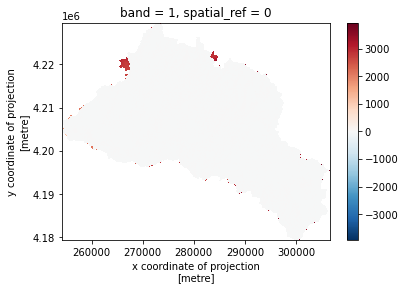

In [159]:
# Code from https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/
# from shapely.geometry import mapping

# lidar_pre_arr = rxr.open_rasterio(lidar_fn, masked=True).squeeze()
# lidar_2019_pre_arr = rxr.open_rasterio(lidar_fn_2019, masked=True).squeeze()

# lidar_clipped = lidar_pre_arr.rio.clip(outline_gdf.geometry.apply(mapping))
# lidar_clipped_2019 = lidar_2019_pre_arr.rio.clip(outline_gdf.geometry.apply(mapping))

# lidar_differences = lidar_clipped_2019 - lidar_clipped

# lidar_differences.plot()

In [168]:
# lidar_differences = atl06sr_gdf['h_mean ASO_3M_PCDTM_USCATE_20191010_20191010 diff'] - atl06sr_gdf['h_mean mcc_dem_3p0m_agg_TUOtrimmed_MANUAL diff']
# lidar_differences.describe()

count    152603.000000
mean        -52.067447
std         395.338362
min       -3858.916016
25%           0.043457
50%           0.312500
75%           0.712402
max         114.337524
dtype: float64

In [160]:
#lidar_clipped_2019.rio.to_raster('../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent.tif')

## Create a giant array of all the relevant snow on ASO measurements for heatmap plotting  
Hasn't worked so far. Will come back to this if David thinks it's necessary (also, Jessica didn't like the heatmap plots anyways so potentially won't need this anyways)

In [104]:
aso_fn_dates = ['../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190324.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190417.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190503.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190705.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_snowdepth_3m_20200413.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_snowdepth_3m_20200522.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_50m_20210225.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405.tif']

In [86]:
# Adapted from David Shean's code
# not the original - changing to try and make applicable to specific dates of ASO/Is2 overlap

def sample_raster_dates(df, src, diff_col=None, date=datetime.date(2019, 3, 12)):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.loc[df['acqdate'] == date].to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    df.loc[df['acqdate'] == date, 'ASO_snowon'] = sm
    dt_str = os.path.splitext(os.path.split(src.name)[-1])[-2].split('_')[-1]
    df.loc[df['acqdate'] == date, 'ASO_snowon_date'] = datetime.datetime.strptime(dt_str, '%Y%m%d').date()

In [87]:
atl06sr_gdf['ASO_snowon'] = pd.Series(dtype=float)
atl06sr_gdf['ASO_snowon_date'] = pd.Series(dtype=float)

for file, date in zip(aso_fn_dates, atl06_dates):
    src = rio.open(file)
    sample_raster_dates(atl06sr_gdf, src, date=date)

In [157]:
rds = rxr.open_rasterio("../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent.tif")
#rds.name = "data"

In [160]:
rds

<xarray.DataArray (band: 1, y: 16770, x: 17500)>
[293475000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.542e+05 2.542e+05 ... 3.066e+05 3.066e+05
  * y            (y) float64 4.23e+06 4.23e+06 4.23e+06 ... 4.179e+06 4.179e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# Killed my kernel, takes too long?

rds = rxr.open_rasterio("../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent.tif")
rds.name = "data"
df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
aso_points_gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)

In [145]:
src = rio.open('../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190324.tif')

In [106]:
type(src)

rasterio.io.DatasetReader

In [146]:
file = src.read(1, masked=True)

In [108]:
type(file)

numpy.ma.core.MaskedArray

In [112]:
file.flatten()

masked_array(data=[-0.0, -0.0, -0.0, ..., -0.0, -0.0, -0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-9999.0,
            dtype=float32)

In [113]:
np.ma.getdata(file)

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [116]:
src = rio.open(aso_fn_dates[0])
file = src.read(1, masked=True)
aso_snowon_array = np.ma.getdata(file.flatten())

for file in aso_fn_dates[1:]:
    src = rio.open(file)
    file = src.read(1, masked=True)
    aso_snowon_array = np.append(aso_snowon_array, np.ma.getdata(file))

In [117]:
aso_snowon_array

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [120]:
aso_snowon_array_fn = '../../data/aso_snowon_array.pkl'

with open(aso_snowon_array_fn, 'wb') as f:
    pickle.dump(aso_snowon_array_fn, f)

In [119]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks


In [136]:
aso_snowon_array.shape

(18653, 21623)

In [137]:
np.ma.getdata(file).shape

(18449, 31464)

In [140]:
file.flatten().shape

(580479336,)

In [147]:
np.ma.getdata(file.flatten()).shape

(403333819,)

In [142]:
slope_fn = '../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_slope_3m.tif'

In [143]:
src_slope = rio.open(slope_fn)
slope_3m = src_slope.read(1, masked=True)

In [144]:
np.ma.getdata(slope_3m.flatten()).shape

(293475000,)

In [148]:
file.shape

(18653, 21623)

In [149]:
slope_3m.shape

(16770, 17500)

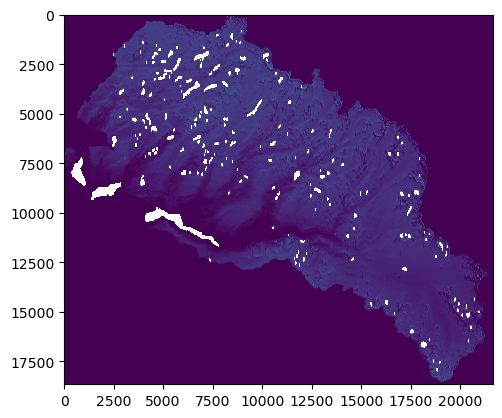

In [150]:
fig, ax = plt.subplots()

plt.imshow(file)

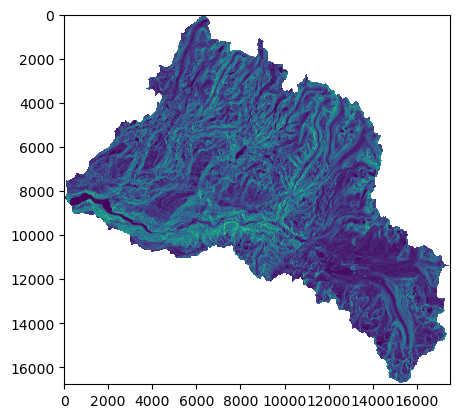

In [151]:
fig, ax = plt.subplots()

plt.imshow(slope_3m)

In [153]:
outline_nolakes

NameError: name 'outline_nolakes' is not defined

<AxesSubplot: >

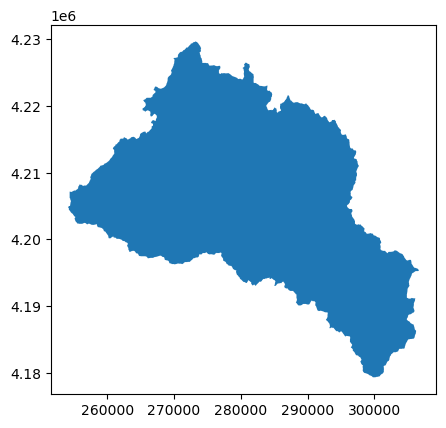

In [152]:
outline_gdf.plot()